# Neural Style Transfer!

In [1]:
# Load Dependencies
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras.backend as K

from keras.applications import vgg19
from keras.preprocessing.image import load_img, img_to_array, save_img
from keras.applications.vgg19 import preprocess_input
from keras.models import Model

%matplotlib inline

Using TensorFlow backend.


# Setup Config Variables / Constants

In [8]:
# Config Variables / Constants

# Images
TARGET_HEIGHT = 512
TARGET_WIDTH = 512
TARGET_CHANNELS = 3

# Image Paths
CONTENT_PATH = '../data/seal.jpeg'
STYLE_PATH = '../data/fauvism-1.jpg'

# VGG 19 Layers
CONTENT_LAYERS = ['block5_conv2']
STYLE_LAYERS = [('block1_conv1', 0.2),
                ('block2_conv1', 0.2),
                ('block3_conv1', 0.2),
                ('block4_conv1', 0.2),
                ('block5_conv1', 0.2)]

print('Num. Content Layers:', len(CONTENT_LAYERS))
print('Num. Style Layers:  ', len(STYLE_LAYERS))

Num. Content Layers: 1
Num. Style Layers:   5


# Helper Functions

### Image Helper Functions

In [9]:
# Image Helper Functions
def show_img(image, title=''):
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

def vgg19_preprocess_img(img):
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def preprocess_img(path_to_img, show = False, title = ''):
    img = load_img(path_to_img, target_size=(TARGET_HEIGHT, TARGET_WIDTH))
    if show:
        show_img(img, title)
    img = img_to_array(img)
    return vgg19_preprocess_img(img)

def deprocess_img(img):
    x = img.copy()
    
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocess_img()")
    
    # Inverse of preprocessing
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    
    # Ensure we're in the range of (0, 255)
    x = np.clip(x, 0., 255.).astype('uint8')
    return x

def generate_noise_image(content_image, noise_ratio = 0.6):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (TARGET_HEIGHT, TARGET_WIDTH, TARGET_CHANNELS)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return vgg19_preprocess_img(input_image)

def generate_img(content_image, noise_ratio = 0.6, show = False):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    # Generate a random noise_image
    img = np.random.uniform(-20, 20, (TARGET_HEIGHT, TARGET_WIDTH, TARGET_CHANNELS)).astype('float32')    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    img = img * noise_ratio + content_image * (1 - noise_ratio)

    if show:
        show_img(img, 'Generated Image')
        
    return vgg19_preprocess_img(img)

def save_image(path_to_save, img):
    img = deprocess_img(img)
    save_img(path_to_save, img, file_format="jpg")
    print('Saved image!')
    

### Loss Helper Functions

In [10]:
# Loss Helper Functions
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

def gram_matrix(a):
    return tf.matmul(a, tf.transpose(a))

In [11]:
# Model Helper Functions
def get_model():
    """ Load VGG19 model with the appropriate outputs """
    model = vgg19.VGG19(include_top=False, weights='imagenet')
    model.trainable = False
    
    content_output = [model.get_layer(layer_name).output for layer_name in CONTENT_LAYERS]
    style_output = [model.get_layer(layer_name).output for layer_name,coeff in STYLE_LAYERS]
    model_outputs = content_output + style_output
    
    return Model(inputs=model.inputs, outputs=model_outputs)

## Load Content, Style, and Generated Images

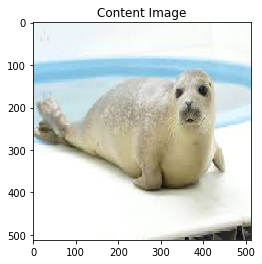

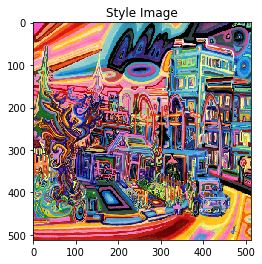

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


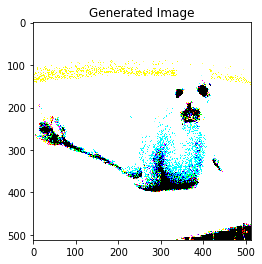

Content Shape:   (1, 512, 512, 3)
Style Shape:     (1, 512, 512, 3)
Generated Shape: (1, 512, 512, 3)
Tensor("model_1/block5_conv2/Relu:0", shape=(1, 32, 32, 512), dtype=float32)
Tensor("model_1/block1_conv1/Relu:0", shape=(1, 512, 512, 64), dtype=float32)
Tensor("model_1/block2_conv1/Relu:0", shape=(1, 256, 256, 128), dtype=float32)
Tensor("model_1/block3_conv1/Relu:0", shape=(1, 128, 128, 256), dtype=float32)
Tensor("model_1/block4_conv1/Relu:0", shape=(1, 64, 64, 512), dtype=float32)
Tensor("model_1/block5_conv1/Relu:0", shape=(1, 32, 32, 512), dtype=float32)
(1, 32, 32, 512)
(1, 512, 512, 64)
(1, 256, 256, 128)
(1, 128, 128, 256)
(1, 64, 64, 512)
(1, 32, 32, 512)


In [12]:
# Load Content, Style, and Generated Images
content_img = preprocess_img(CONTENT_PATH, show=True, title='Content Image')
style_img = preprocess_img(STYLE_PATH, show=True, title='Style Image')
generated_img = generate_img(content_img[0], show=True)

print('Content Shape:  ', content_img.shape)
print('Style Shape:    ', style_img.shape)
print('Generated Shape:', generated_img.shape)

with tf.Session() as sess:
    x = tf.Variable(content_img)
    model = get_model()
    out = model(x)
    sess.run(tf.global_variables_initializer())
    for i in out:
        print(i)
    for i in sess.run(out):
        print(i.shape)

# Cost Functions

### Content Cost

In [13]:
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C = tf.reshape(a_C, [n_C, n_H * n_W])
    a_G = tf.reshape(a_G, [n_C, n_H * n_W])
    
    constant = 1/(4 * n_H * n_W * n_C)
    return constant * tf.reduce_sum(tf.square(a_C - a_G))

tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))
    
    print("Should be =", str(6.76559))


J_content = 6.7655935
Should be = 6.76559


### Style Cost

In [14]:
def compute_style_cost_one_layer(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape(tf.transpose(a_S), [n_C, n_H * n_W])
    a_G = tf.reshape(tf.transpose(a_G), [n_C, n_H * n_W])
        
    gram_S = gram_matrix(a_S)
    gram_G = gram_matrix(a_G)
    
    constant = 1/(4 * n_C**2 * (n_H * n_W)**2)
    return constant * tf.reduce_sum(tf.square(gram_S - gram_G))


tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_style_cost_one_layer(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))
    print("Should be     =", str(9.19028))

J_style_layer = 9.190277
Should be     = 9.19028


In [15]:
def compute_style_cost(style_activations, generated_activations):
    J_style = 0
    for i,(layer_name, coeff) in enumerate(STYLE_LAYERS):
        a_S = style_activations[i]
        a_G = generated_activations[i]
        J_curr = compute_style_cost_one_layer(a_S, a_G)
        J_style += coeff * J_curr
    return J_style

### Total Cost

In [16]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    return alpha * J_content + beta * J_style

def compute_grads(loss, image):
    return K.gradients(loss, image)

tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J         = " + str(J))
    print("Should be =", str(35.34667875478276))

J         = 35.34667875478276
Should be = 35.34667875478276


# Solving the optimization problem

In [17]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [18]:
# Load the Images (again)
content_img = preprocess_img(CONTENT_PATH, show=False, title='Content Image')
style_img = preprocess_img(STYLE_PATH, show=False, title='Style Image')
generated_img = generate_img(content_img[0], show=False)
# generated_img = tf.Variable(preprocess_img('../images/nst-180.jpg', show=False, title='Generated Image'), name='generated_img', dtype=tf.float32)

content_img = tf.constant(content_img, name='content_img', dtype=tf.float32)
style_img = tf.constant(style_img, name='style_img', dtype=tf.float32)
generated_img = tf.Variable(generated_img, name='generated_img', dtype=tf.float32)

# Get the model
model = get_model()

# Define the Model

In [19]:
def model_nn(sess, input_image, num_iterations = 500):    
    generated_img = input_image
    a_C = model(content_img)[0]
    a_S = model(style_img)[1:]
    a_G = model(generated_img)
    
    J_content = compute_content_cost(a_C, a_G[0])
    J_style = compute_style_cost(a_S, a_G[1:])
    J = total_cost(J_content, J_style)
    
    optimizer = tf.train.AdamOptimizer(2.0)
    grads = compute_grads(J, generated_img)[0]
    train_step = optimizer.apply_gradients([(grads, generated_img)])
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    sess.run(tf.global_variables_initializer())
    
    for i in range(num_iterations):        
        sess.run(train_step)
        
        clipped = tf.clip_by_value(generated_img, min_vals, max_vals)
        generated_img.assign(clipped)
        
        # Print every 20 iteration.
        if i % 20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js) + '\n')
            save_img('../images/nst-{}.jpg'.format(i), sess.run(generated_img)[0])
    
    save_img('../images/nst-final.jpg', sess.run(generated_img)[0])


In [ ]:
model_nn(sess, generated_img)

Iteration 0 :
total cost = 79539.85
content cost = 0.0014934796
style cost = 1988.496



In [ ]:
print(model.summary())